<div>
<center>
    <img src="https://datascientest.fr/train/assets/logo_datascientest.png", style="height:150px">
</center> 
</div>

<hr style="border-width:2px;border-color:##75DFC1">
<br>
<center> <h1> Segmentation de régions nuageuses </h1> </center> <br><br>
<center> <h2> Partie 3 - Multi-Classification </h2> </center> <br><br>
<hr style="border-width:2px;border-color:##75DFC1">

<div class="panel" style="border-width:2px;border-color:##75DFC1"> 
    <div class="panel-body">
<h3> Contexte du sujet </h3>
<p>Il s’agit d’analyser et d’identifier dans chaque image satellite les régions qui contiennent une formation nuageuse particulière (poisson, fleur, gravier, sucre). Ces segmentations aident à la projection climatique en permettant de démystifier une des variables importantes du climat.</p>
        
<h3>Data</h3>
<p>Les données sont des images satellites labellisées, un set de donnée test non labellisé est disponible.<br>
[Données Kaggle]<span style="color:#660099;">
    <a href="https://www.kaggle.com/c/understanding_cloud_organization/">
        https://www.kaggle.com/c/understanding_cloud_organization/></a></p>

<h3> Objet </h3>
<p>Cette phase consiste a implémenter un modele de multi-classification des images satellites afin d'identifier la présence ou l'absence dans l'image des quatre classes de formations nuageuses (Gravier, Poisson, Sucre et Fleur).</p>

</div>       
</div>

### Groupe
> * Cathy Baynaud-Samson,
> * Yann Bernery
> * José Castro
> * Ludovic Changeon

## **1 - Import des librairies**


In [ ]:
# Création de deux répertoires pour stocker le Git et les librairies
!mkdir nebulaTemp -p
!mkdir packages -p

# Copie des sources des librairies projet depuis le Github
!git clone https://github.com/DataScientest/nebula/ ./nebulaTemp --dissociate
!cp ./nebula/packages/* ./packages

# Suppression de la copie du repository source
!rm nebulaTemp -r

In [1]:
# Import des librairies du projet
import packages

In [2]:
# Librairies génériques
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Librairies images
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2

# Interface CNN Keras
import keras_preprocessing
import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.utils import to_categorical

# Scikit Learn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split


## **2 - Import des données**

Les images compressées sont copiées depuis google drive dans le répertoire courant puis décompressées. A noter que les images ont au prealable fait l'objet d'une réduction, dans le but de gagner d'une part en espace de stockage et d'autre part en temps d'execution. Il est en effet possible de les charger en mémoire.

In [5]:
zip_path = "/content/drive/MyDrive/cloud_training_8.zip"
packages.copy_data_from_drive(from_path='/content/drive/MyDrive/', 
                              filename = 'cloud_training_8.zip',to_path = '.')

True

## **3 - Pré-traitement des données**

### **3.1 - Chargement et codage disjonctif des classes de nuages**

On récupère le contenu de l'index des images et on crée les indices des classes

In [6]:
df = packages.load_train(filename = 'train.csv')
train_partial = packages.label_parsing(dataframe=df, sep='_',drop_na=True)
train_encoded = packages.one_hot_encoding(dataframe=train_partial, reset_index = False)
train_encoded.head()

Fish  Flower  Gravel  Sugar
image                                   
0011165.jpg     1       1       0      0
002be4f.jpg     1       1       0      1
0031ae9.jpg     1       1       0      1
0035239.jpg     0       1       1      0
003994e.jpg     1       0       1      1

Des dataframes sont créés pour faciliter les traitements.

In [7]:
#Affectation de data (sous forme de nom des images) et target
data = pd.DataFrame(train_encoded.index.values,columns = ['nom'])
labels = train_encoded.columns
target = pd.DataFrame(train_encoded.values.astype('float32'),
                      columns=['class0','class1','class2','class3'],
                      index=train_encoded.index)

### **3.2 - Chargement et séparation des images**



Nous réservons ici 5% des images du set d'apprentissage pour effectuer des tests. Ainsi nous nous assurons que le modele n'aura jamais vu ces images.

In [8]:
# Définition des paramètres

preload = 0 # chargement des images en mémoire (1) ou pas (0)
ratio = 1/8 # facteur de réduction (pour info)
repTrain  = 'train_images_8/'

# Initialisation des tailles d'images
path = os.path.join(repTrain, data['nom'][0])
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
taille = img.shape
tx = np.int(taille[0])
ty = np.int(taille[1])

# On charge les images dans data_full
data_full=data

# On sépare les données en 'train' / 'test', on met de côté 'test' pour la fin
X_data, X_test, y_data, y_test = packages.splitValid(data_full, 
                                                     target, 
                                                     randomState=123, 
                                                     test_size=0.05, 
                                                     shuffle = True)

On vérifie les proportions de chacune des classes afin de controler qu'il n'y a aucun déséquilibre préjudiciable.

In [9]:
# Vérifications des proportions pour chacun des sous-ensembles
proportions = [y_data.iloc[:,j].value_counts(normalize=True) for j in range(4)]
for j in range(len(labels)):
    print('Classe ', labels.values[j])

    for i,k in enumerate(proportions[j]): 
        print('Flag {} : {:2.2%}'.format(i, k))
    print('\n')    

Classe  Fish
Flag 0 : 50.19%
Flag 1 : 49.81%


Classe  Flower
Flag 0 : 57.23%
Flag 1 : 42.77%


Classe  Gravel
Flag 0 : 52.90%
Flag 1 : 47.10%


Classe  Sugar
Flag 0 : 67.44%
Flag 1 : 32.56%




## **4 - Implémentation du modele**


### **4.1 - Spécification de l'architecture**

In [10]:
def buildModel():
    # Model sequentiel
    model = Sequential()

    # Première couche de convolution / maxpooling
    conv11 = Conv2D(filters = 30, kernel_size = (5,5), input_shape = (tx, ty, 1), 
                    activation = 'relu', padding = 'valid')
    pool1 = MaxPooling2D(pool_size = (5,5))

    # Deuxième couche de convolution / maxpooling
    conv21 = Conv2D(filters = 8, kernel_size = (5,5), activation = 'relu', padding = 'valid')
    pool2 = MaxPooling2D(pool_size = (5,5))

    # Interface avec les couches de neurones
    drop = Dropout(rate = 0.2)
    flat = Flatten()

    # Couches de neurones
    dense1 = Dense(units = 128, activation = 'relu')
    drop2 = Dropout(rate = 0.2)
    dense2 = Dense(units = 4, activation = 'sigmoid')

    # Ajout de toutes les couches dans le modèle
    listeLayers = [conv11, pool1, conv21, pool2, drop, flat, dense1, drop2, dense2]
    for layer in listeLayers :
        model.add(layer)

    return model


In [11]:
model = buildModel()      
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 171, 258, 30)      780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 51, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 47, 8)         6008      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 9, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 9, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 432)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

### **4.2 - Représentation intermédiaire des couches du modele**

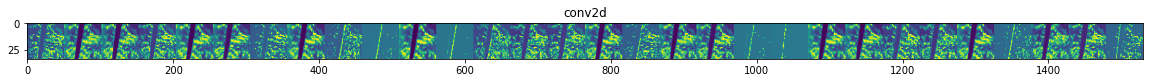

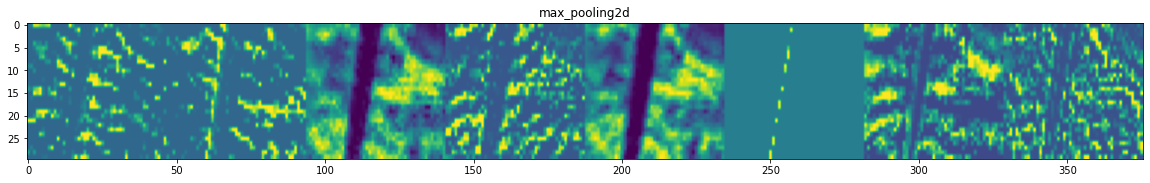

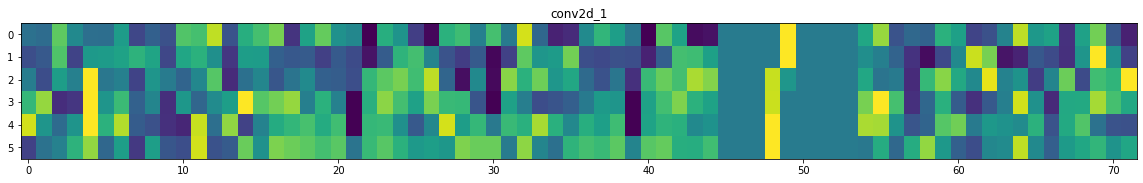

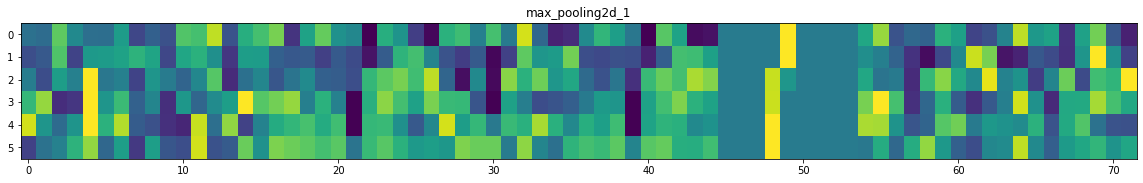

In [12]:
import numpy as np
import random
import tensorflow as tf
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Nous definissons une instance de notre modele qui va prendre en entree une image
# et qui va ressortir une representation intermediaire des couches (en dehors de
# la premiere)
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img_test = '0a709e6.jpg'
img_path = os.path.join(repTrain, img_test)
img = load_img(img_path, target_size=(tx, ty), color_mode="grayscale") 

x   = img_to_array(img)                          
x   = x.reshape((1,) + x.shape)                  

# Normalisation
x /= 255.0

# Nous lacons notre image a travers notre modele
successive_feature_maps = visualization_model.predict(x)

# Nous recuperons les noms des couches de notre modele
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Affichage des representations intermediaires
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:
    
        #-------------------------------------------
        # Le traitement est realise uniquement sur les couches de convolution et max-pooling
        # et non sur les couches denses
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        sizew       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
        sizeh       = feature_map.shape[ 2]

        # dimensionnement d'une grille
        display_grid = np.zeros((sizew, sizeh * n_features))
    
        #-------------------------------------------------
        # traitement de preparation a la visualisation
        #-------------------------------------------------
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * sizeh : (i + 1) * sizeh] = x 

        #-----------------
        # Affichage de la grille
        #-----------------

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## **5 - Fonctions utilitaires**

Fonction de compilation.

In [13]:
def compileModel(model, lr=.001):
  # Compilation du modèle
  opt = keras.optimizers.Adam(lr=lr) #optimizer = opt
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['categorical_accuracy']) #categorical_accuracy
  return model

Fonction d'apprentissage

In [14]:
def trainModel(modelIO, checkpoint, train_gen, validation_gen, train_steps, valid_steps, weights, batchSize=32, epochs=30, verbose=0):
  # Entraînement du modèle
  ## Définition d'un chemin vers un 'checkpoint', sauvegarde via callback
  ## Prend deux générateurs (train et valid)

  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint,
      save_weights_only=True,
      monitor='categorical_accuracy', #categorical_accuracy
      mode='max',
      save_best_only=True)

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=2, min_lr=0.00001, min_delta = 0.001)
  callbacks = [model_checkpoint_callback, reduce_lr]
  training = modelIO.fit(train_gen,
                            steps_per_epoch = train_steps,
                            epochs = epochs,
                            validation_data = validation_gen,
                            validation_steps = valid_steps,
                            callbacks = callbacks,  class_weight = weights,
                       verbose = verbose)
  return training

## **6 - Compilation et entraînement**

Paramètres et première préparation du jeu de données

In [15]:
checkpointPath = 'chkpt_classif/'
checkpointBase = checkpointPath + 'multiclassif'  #'/content/drive/MyDrive/checkpoints/checkpointTest' #checkpoint2
batchSize = 32
epochs = 10
class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}

# Les données et le modèle sont préparés "à blanc", au cas où on ne souhaiterait que recharger des poids d'un entraînement précédent

X_train, X_valid, y_train, y_valid = packages.splitValid(X_data, y_data,
                                                         randomState=123, test_size=0.2, shuffle=True) # séparation train / valid

trainGen = packages.makeGen(X_train, y_train, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1) # Création ImageGenerators
validGen = packages.makeGen(X_valid, y_valid, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1)
compileModel(model, lr=.001); # Compilation

Found 4214 validated image filenames.
Found 1054 validated image filenames.


Entraînement du modele. Nous procédons en trois phases successives pendant lesquelles la repartition des images entre le set d'apprentissage et le set de validation est aléatoirement remaniée.

In [25]:
# Affichage ou pas de tous les epochs
verboseTraining = 1
#=====================Phase 1
print("Début phase 1...")
checkpoint = checkpointBase + '_phase1'
%time training1 = trainModel(model, checkpoint, train_gen = trainGen, validation_gen = validGen, weights = class_weights, train_steps =len(X_train)//batchSize, valid_steps =len(X_valid)//batchSize, batchSize = batchSize, epochs = epochs, verbose = verboseTraining)

#=====================Phase 2
print("\n\nDébut phase 2...")
X_train, X_valid, y_train, y_valid = packages.splitValid(X_data, y_data, randomState=124, test_size=0.2, shuffle=True)
trainGen = packages.makeGen(X_train, y_train, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1) # Création ImageGenerators
validGen = packages.makeGen(X_valid, y_valid, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1)

compileModel(model, lr=.0001)
checkpoint = checkpointBase + '_phase2'
%time training2 = trainModel(model, checkpoint, train_gen = trainGen, validation_gen = validGen, weights = class_weights,  train_steps =len(X_train)//batchSize, valid_steps =len(X_valid)//batchSize, batchSize = batchSize, epochs = epochs, verbose = verboseTraining)

#=====================Phase 3
print("\n\nDébut phase 3...")
# On pénalise plus fortement les classes moins bien détectées
class_weights = {0: 5.,
                1: 5.,
                2: 5.,
                3: 1.}
X_train, X_valid, y_train, y_valid = packages.splitValid(X_data, y_data, randomState=3, test_size=0.2, shuffle=True)
trainGen = packages.makeGen(X_train, y_train, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1) # Création ImageGenerators
validGen = packages.makeGen(X_valid, y_valid, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1)
compileModel(model, lr=.00001)
checkpoint = checkpointBase + '_phase3'
%time training3 = trainModel(model, checkpoint, train_gen = trainGen, validation_gen = validGen, weights = class_weights, train_steps =len(X_train)//batchSize, valid_steps =len(X_valid)//batchSize, batchSize = batchSize, epochs = epochs, verbose = verboseTraining)

print('\n\nFin de l\'entraînement')

Début phase 1...
Epoch 1/10
131/131 [==============================] - 6s 39ms/step - loss: 0.6819 - categorical_accuracy: 0.1003 - val_loss: 0.6710 - val_categorical_accuracy: 0.0684
Epoch 2/10
131/131 [==============================] - 5s 35ms/step - loss: 0.6756 - categorical_accuracy: 0.0775 - val_loss: 0.6542 - val_categorical_accuracy: 0.0762
Epoch 3/10
131/131 [==============================] - 4s 34ms/step - loss: 0.6568 - categorical_accuracy: 0.1426 - val_loss: 0.6334 - val_categorical_accuracy: 0.2275
Epoch 4/10
131/131 [==============================] - 5s 35ms/step - loss: 0.6389 - categorical_accuracy: 0.2118 - val_loss: 0.6298 - val_categorical_accuracy: 0.1514
Epoch 5/10
131/131 [==============================] - 5s 35ms/step - loss: 0.6135 - categorical_accuracy: 0.2404 - val_loss: 0.5974 - val_categorical_accuracy: 0.2246
Epoch 6/10
131/131 [==============================] - 5s 35ms/step - loss: 0.5958 - categorical_accuracy: 0.2665 - val_loss: 0.5854 - val_categorica

## **7 - Evaluation du modele**

### **7.1 - Evolution de la perte et de l'accuracy**

In [26]:
# Réinitialisation de train_acc (optionnel)
train_acc = None
val_acc = None
train_perte = None
val_perte= None

In [27]:
# Tracé du CR de l'apprentissage

precision = 'categorical_accuracy'
val_precision = 'val_categorical_accuracy'
loss = 'loss'
val_loss = 'val_loss'
if train_acc is None: # si les sauvegardes de tracés ne sont pas initialisées
  train_acc = training1.history[precision].copy()
  val_acc = training1.history[val_precision].copy()
  train_perte= training1.history[loss].copy()
  val_perte = training1.history[val_loss].copy()
else :
  train_acc.extend(training1.history[precision])
  val_acc.extend(training1.history[val_precision])
  train_perte.extend(training1.history[loss])
  val_perte.extend(training1.history[val_loss])

train_acc.extend(training2.history[precision])
val_acc.extend(training2.history[val_precision])
train_acc.extend(training3.history[precision])
val_acc.extend(training3.history[val_precision])

train_perte.extend(training2.history[loss])
val_perte.extend(training2.history[val_loss])
train_perte.extend(training3.history[loss])
val_perte.extend(training3.history[val_loss])

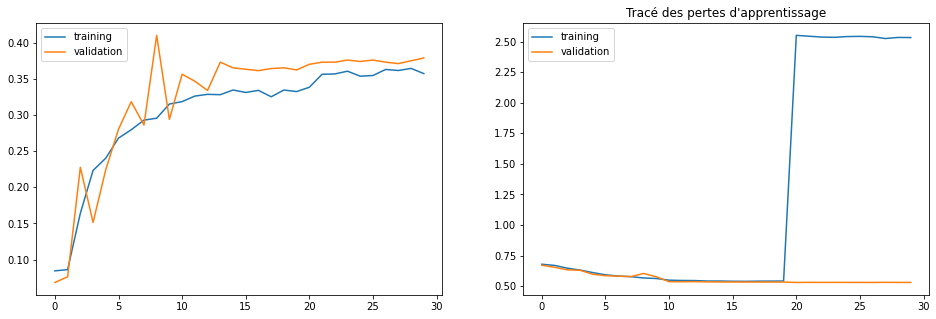

In [28]:
# Affichage du graphe
fig,ax = plt.subplots(nrows = 1, ncols =2, figsize = (16,5))
#plt.subplot(211)
ax[0].plot(train_acc,label = 'training')
ax[0].plot(val_acc, label = 'validation')
plt.title('Tracé des précisions d\'apprentissage')
ax[0].legend()

#plt.subplot(212)
ax[1].plot(train_perte,label = 'training')
ax[1].plot(val_perte,label = 'validation')
plt.title('Tracé des pertes d\'apprentissage')
plt.legend()
plt.show()

### **7.2 - Prédictions et score F1 par classe au seuil par défaut (set de test)**


Création d'un générateur d'images de test

In [29]:
# Création d'un générateur de test
testGen = packages.makeGen(X_test, y_test, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1)

Found 278 validated image filenames.


 Utilisation de la fonction d'évaluation interne du modèle

In [30]:
# Récupération du checkpoint
model.load_weights(checkpointPath+'checkpoint3')

# Evaluation du modèle
evaluation = model.evaluate(testGen, steps = len(y_test)//batchSize)

8/8 [==============================] - 0s 26ms/step - loss: 0.5495 - categorical_accuracy: 0.4141


Observation des résultats par classe

*   Définition d'une fonction d'évaluation



In [31]:
# Fonction d'affichage de l'évaluation détaillée
## 1: classification_report
## 2: matrices de confusion par classe

def crosstabsFromX(dataGen, target, seuil, batchSize):
  y_pred = model.predict(dataGen, batch_size=batchSize, steps=None)
  y_pred_final = np.empty((y_pred.shape[0],y_pred.shape[1]))
  for i in range(len(y_pred[:])):
      for j in range(4):
          y_pred_final[i] = np.where(y_pred[i,:]>=seuil,1,0)
  print(classification_report(target, y_pred_final, zero_division = 0))
  for i in range(4):
      y_pred_cx = y_pred_final[:,i]
      y_test_cx = target.iloc[:,i]
      print(labels[i])
      print((pd.crosstab(y_test_cx,y_pred_cx,rownames=['Réel'], colnames=['Prédit'],normalize=True)).round(2)*100)
      print()
  return y_pred_final

* Application de la fonction aux données de test isolées au début

In [32]:
# Choix d'un seuil de 0.4 (meilleur f1-score)
y_pred_final = crosstabsFromX(testGen, y_test, 0.4, 32)

              precision    recall  f1-score   support

           0       0.56      0.81      0.66       137
           1       0.65      0.73      0.69       112
           2       0.64      0.88      0.74       152
           3       0.75      0.94      0.84       198

   micro avg       0.66      0.85      0.74       599
   macro avg       0.65      0.84      0.73       599
weighted avg       0.66      0.85      0.74       599
 samples avg       0.68      0.88      0.73       599

Fish
Prédit   0.0   1.0
Réel              
0.0     20.0  31.0
1.0      9.0  40.0

Flower
Prédit   0.0   1.0
Réel              
0.0     44.0  16.0
1.0     11.0  29.0

Gravel
Prédit   0.0   1.0
Réel              
0.0     18.0  27.0
1.0      7.0  48.0

Sugar
Prédit  0.0   1.0
Réel             
0.0     7.0  22.0
1.0     4.0  67.0



### **7.3 - Evaluation du set complet**

On évalue tout le jeu de données, classe par classe

In [34]:
fullGen = packages.makeGen(data_full, target, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1)
y_pred_final = crosstabsFromX(fullGen, target, 0.4, 32)
prediction = pd.DataFrame(y_pred_final, index = target.index, columns = target.columns)

Found 5546 validated image filenames.
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      2781
           1       0.74      0.84      0.79      2365
           2       0.66      0.91      0.76      2939
           3       0.75      0.96      0.84      3751

   micro avg       0.70      0.90      0.79     11836
   macro avg       0.70      0.90      0.78     11836
weighted avg       0.70      0.90      0.79     11836
 samples avg       0.72      0.92      0.77     11836

Fish
Prédit   0.0   1.0
Réel              
0.0     26.0  24.0
1.0      6.0  44.0

Flower
Prédit   0.0   1.0
Réel              
0.0     45.0  13.0
1.0      7.0  36.0

Gravel
Prédit   0.0   1.0
Réel              
0.0     22.0  25.0
1.0      5.0  48.0

Sugar
Prédit   0.0   1.0
Réel              
0.0     11.0  21.0
1.0      3.0  65.0



### **7.4 - Confusion du modele**

Nous établirons par la suite des scores de prédiction par image précis, cependant nous pouvons nous concentrer tout d'abord sur le nombre de classes correctement prédites.

Ainsi nous créons un score de confusion pour chaque image
* (np.dot(target, pred)) + complément à 1
* 0 : aucune classe bien prédite
* 4 : toutes les classes bien prédites

In [35]:
score = []
for i in range(target.shape[0]):
  temp = np.dot(target.iloc[i].values, prediction.iloc[i].values) +  np.dot(-1+target.iloc[i].values, -1+prediction.iloc[i].values)
  score.append(temp)
target['score'] = score
resultat = target['score'].value_counts()
resultat.sort_index()

0.0      15
1.0     272
2.0    1271
3.0    2347
4.0    1641
Name: score, dtype: int64

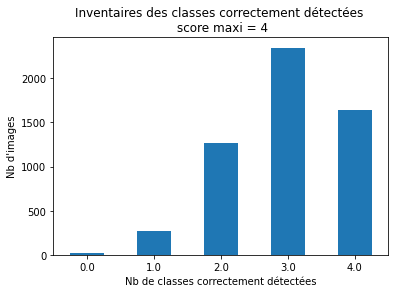

In [36]:
resultat.sort_index().plot.bar(rot = 0)
plt.xlabel('Nb de classes correctement détectées')
plt.ylabel('Nb d\'images')
plt.title('Inventaires des classes correctement détectées \n score maxi = 4')
plt.show()

Cet inventaire est a rapprocher des analyses effectuées lors de la phase exploratoire. Nous pouvons cependant remarquer qu'une tendance se dégage. En effet bien que le nombre d'images a 4 classes ne soit pas tres élevé, le nombre d'images correctement prédites est proportionnellement élevé. Nous pourrons vérifier ce sentiment par les analyses qui suivent.

### **7.5 - Vérification de l'origine des images (train/test)**

In [37]:
origine=[]
for i,val in enumerate(target.index):
  if any(y_test.index == val):
    origine.append('test')
  else:
    origine.append('train')
target['origine']=origine

In [38]:
(target.groupby(['origine','score']).agg(sum)).astype('int')

class0  class1  class2  class3
origine score                                
test    1.0        12      18      17      12
        2.0        29      32      27      44
        3.0        60      49      64      90
        4.0        36      13      44      52
train   0.0         4       9       1       1
        1.0        99     111      77      93
        2.0       508     506     478     623
        3.0      1113     929    1179    1544
        4.0       920     698    1052    1292

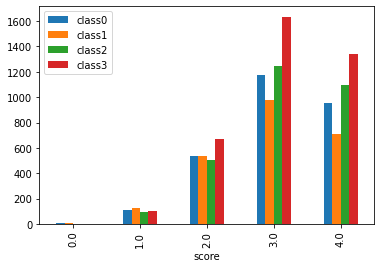

In [39]:
target.groupby('score').agg(sum).plot.bar()
plt.show()

## **8 - Prédictions et analyses**

### **8.1 - Quelques prédictions**

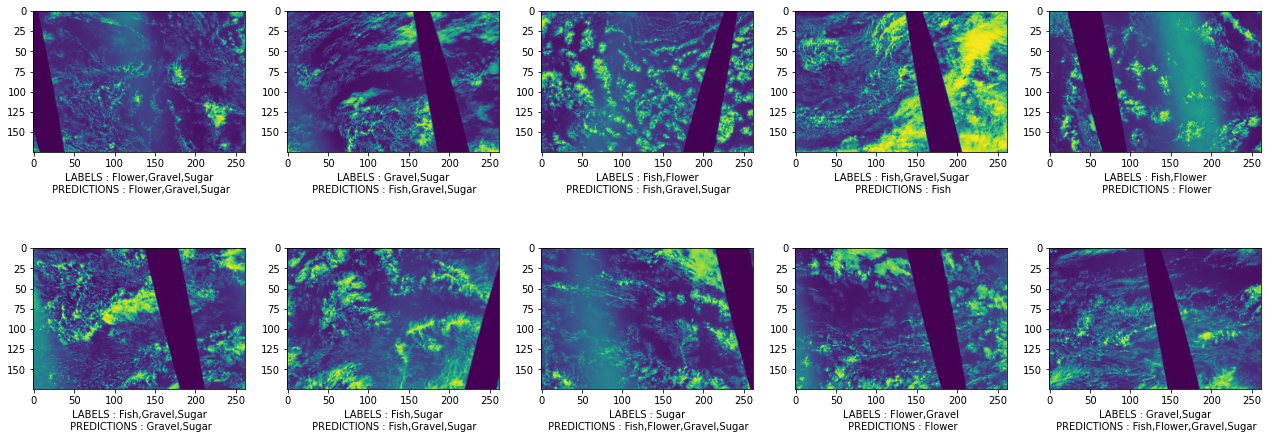

In [40]:
import random

plt.figure(figsize=(22,8))

j = 0
for i in range(10):
    j = j + 1
    plt.subplot(2,5,j)
    row = y_test.sample()
    imageName = row.index.values[0]
    indice = np.where(y_test.index==imageName)[0]
    im = plt.imread(os.path.join(repTrain, imageName))
    #plt.xlabel('image indice '+str(indice)+'\n LABELS : '+ packages.get_labels(y_truePred[indice])+'\n PREDICTIONS : ' + packages.get_labels(y_predPred[indice]))
    plt.xlabel('LABELS : '+ packages.get_labels(row.iloc[0,:].tolist())+'\n PREDICTIONS : ' + packages.get_labels(y_pred_final[indice,][0]))
    
    row.values.tolist()
    plt.imshow(im)

plt.show()

### **8.2 - Détermination d'un scoring individuel inter-classe par image**

In [41]:
def calculIndScore(indice, threshold=[0.5, 0.5, 0.5, 0.5]):
    precisions = 0
    recalls = 0
    vp = 0
    fp = 0
    fn = 0
    vn = 0
    for class_i in range(len(labels.values)):
        #if indice == 0:
        #    print(y_predPred[indice][class_i], seuilsPred[class_i], y_truePred[indice][class_i])
        if y_pred_final[indice][class_i] >= threshold[class_i] and y_test.iloc[indice,class_i] == 1:
            vp += 1
        if y_pred_final[indice][class_i] >= threshold[class_i] and y_test.iloc[indice,class_i] == 0:
            fp += 1
        if y_pred_final[indice][class_i] < threshold[class_i] and y_test.iloc[indice,class_i] == 1:
            fn += 1
        if y_pred_final[indice][class_i] < threshold[class_i] and y_test.iloc[indice,class_i] == 0:
            vn += 1    

    precisions = 0 if (vp + fn == 0) else (vp / (vp + fn)) 
    recalls = 0 if (vp + fp == 0) else (vp / (vp + fp))
    if (precisions + recalls) == 0:
        score = 0
    else:
        score = 2 * (precisions*recalls) / (precisions + recalls)
  
    return score

scores = []
for i in range(y_test.shape[0]):
    scores.append(calculIndScore(i))

y_score = y_test
y_score.columns = labels.values
y_score = y_score.reset_index()
pred_proba = pd.DataFrame.from_records(y_pred_final, columns=[s + '_prediction' for s in labels.values])
y_score = y_score.join(pred_proba)

#On joint egalement les scores calcules
y_score['score'] = scores
y_score.head(5)

image  Fish  Flower  ...  Gravel_prediction  Sugar_prediction     score
0  7405a00.jpg   0.0     1.0  ...                0.0               0.0  0.666667
1  5530c6e.jpg   1.0     0.0  ...                1.0               1.0  0.666667
2  a7aff91.jpg   1.0     0.0  ...                0.0               1.0  0.400000
3  9fb0c6e.jpg   1.0     0.0  ...                1.0               1.0  0.666667
4  7250b61.jpg   1.0     1.0  ...                1.0               1.0  0.666667

[5 rows x 10 columns]

### **8.3 - Analyse des images les moins bien prédites**

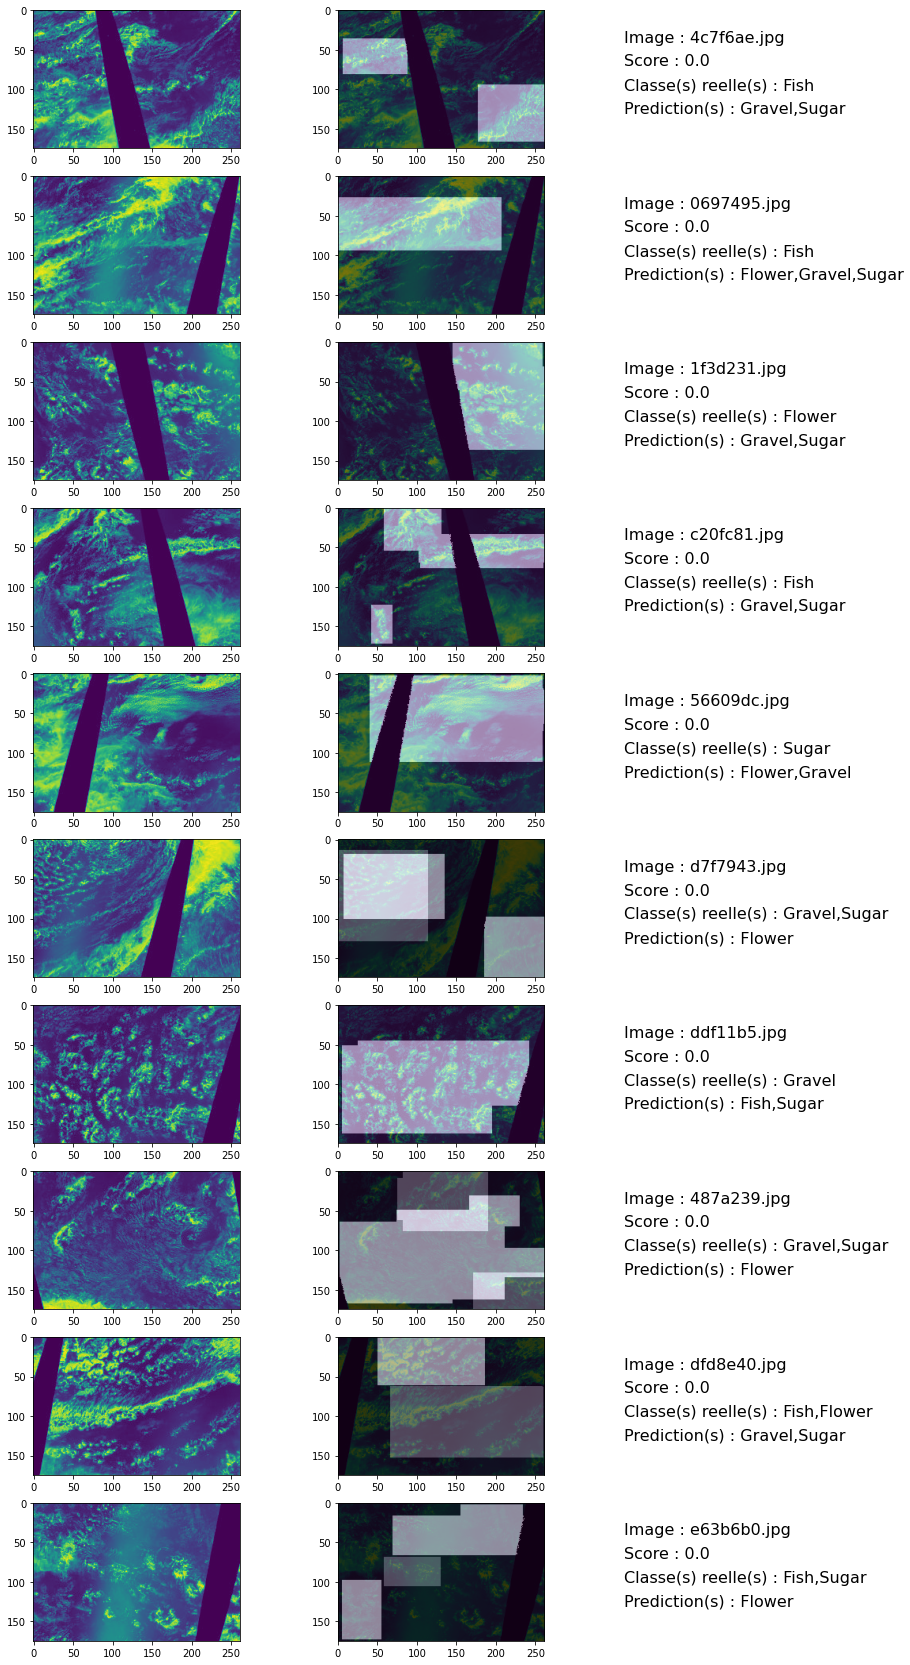

In [42]:
# 10 images parmi les moins bien predites
flop10 = y_score.sort_values('score').head(10)
flop10 = flop10.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 30))

j= 0
for i in range(10):
    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, flop10.image[i]))
    plt.imshow(im)  

    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, flop10.image[i]))
    plt.imshow(im)    
    for index, row in train_partial[train_partial.image==flop10.image[i]].iterrows():
        mask = packages.rleToMask(row['EncodedPixels'])
        plt.imshow(cv2.resize(mask, (ty, tx)) , alpha=0.5, cmap="gray")  

    fontSize = 16
    plt.text(im.shape[1]+100, 40, 'Image : ' + flop10.image[i], fontsize=fontSize)
    plt.text(im.shape[1]+100, 70, 'Score : ' + str(flop10.score[i]), fontsize=fontSize)
    plt.text(im.shape[1]+100, 100, 'Classe(s) reelle(s) : ' + packages.get_labels(flop10.iloc[i,1:5]), fontsize=fontSize) 
    plt.text(im.shape[1]+100, 130, 'Prediction(s) : ' + packages.get_labels(flop10.iloc[i,5:9]), fontsize=fontSize)       

plt.show()

### **8.4 - Analyse des images les mieux prédites**

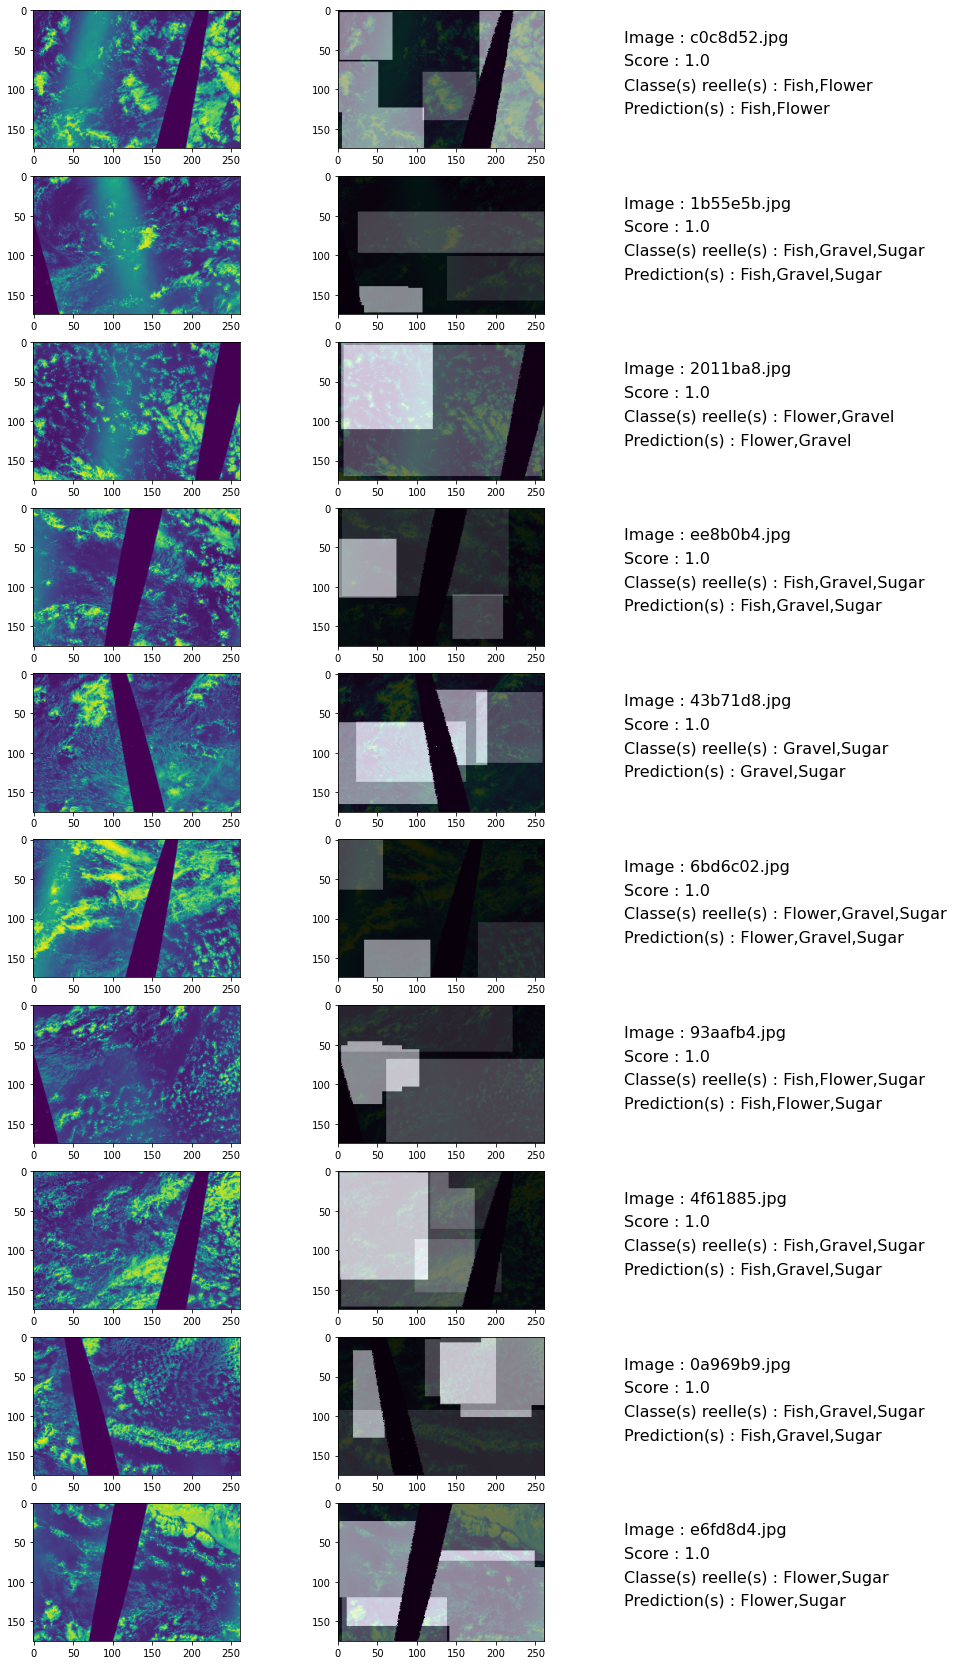

In [43]:
# 10 images parmi les mieux predites
top10 = y_score.sort_values('score').tail(10)
top10 = top10.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 30))

j= 0
for i in range(10):
    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, top10.image[i]))
    plt.imshow(im)  

    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, top10.image[i]))
    plt.imshow(im)    
    for index, row in train_partial[train_partial.image==top10.image[i]].iterrows():
        mask = packages.rleToMask(row['EncodedPixels'])
        plt.imshow(cv2.resize(mask, (ty, tx)) , alpha=0.5, cmap="gray")  

    fontSize = 16
    plt.text(im.shape[1]+100, 40, 'Image : ' + top10.image[i], fontsize=fontSize)
    plt.text(im.shape[1]+100, 70, 'Score : ' + str(top10.score[i]), fontsize=fontSize)
    plt.text(im.shape[1]+100, 100, 'Classe(s) reelle(s) : ' + packages.get_labels(top10.iloc[i,1:5]), fontsize=fontSize) 
    plt.text(im.shape[1]+100, 130, 'Prediction(s) : ' + packages.get_labels(top10.iloc[i,5:9]), fontsize=fontSize)       

plt.show()

### **8.5 - Correlation nombre de classes / score de prédiction**

On constate que dans une certaine mesure, moins il y a de zones nuageuses a predire dans une image, plus le score de prédiction est faible. Ceci est statistiquement compréhensible et prévisible.

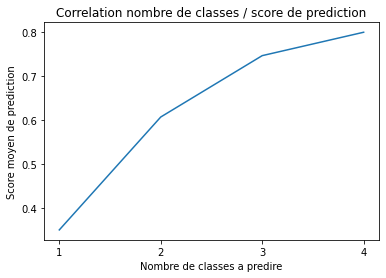

In [44]:
y_score['nb_classes'] = y_score.Fish + y_score.Flower + y_score.Gravel + y_score.Sugar
setMoyen = y_score.groupby('nb_classes').mean()

plt.plot(setMoyen.index, setMoyen.score)
plt.xticks(np.arange(min(setMoyen.index), max(setMoyen.index)+1, 1.0))
plt.xlabel('Nombre de classes a predire')
plt.ylabel('Score moyen de prediction')
plt.title('Correlation nombre de classes / score de prediction')
plt.show()

### **8.6 - Correlation surface moyenne des zones / score de prédiction**

Il est difficile d'établir un lien direct entre la taille des surfaces a prédire et la qualité de prédiction. On constate neanmoins sur les violons ci-dessous que les classes bien prédites ont une surface relativement homogene. Ceci se traduit par une préominence plus marquée autour de la médiane pour les scores moyens et bons.

In [45]:
def surfaceMoyenne(image):

    surface_total = 0
    nb_surface = 0

    for i, row in train_partial[train_partial.image==image].iterrows():
        rle = row['EncodedPixels']

        #Initialisation de la surface courante
        surface_total += packages.surfaceFromRle(row['EncodedPixels'])
        nb_surface += 1

    return surface_total / nb_surface

y_score['surface_moyenne'] = y_score.apply(lambda row : surfaceMoyenne(row['image']), axis = 1)

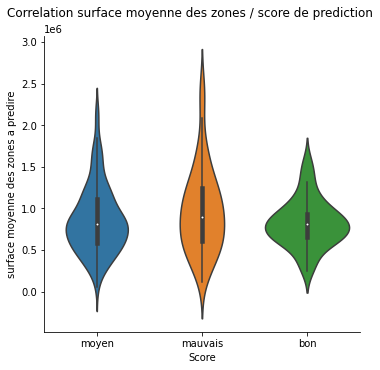

In [46]:
def score(data):
    if data <= 0.4 :
        return 'mauvais'      
    elif data <= 0.8 :  
        return 'moyen'      
    else:
        return 'bon'

y_score['cat_score'] = y_score['score'].apply(score)

ax = sns.catplot(x=y_score['cat_score'], 
                 y='surface_moyenne',
                 data=y_score, 
                 kind = 'violin');
ax.set_axis_labels("Score", "surface moyenne des zones a predire")

ax.fig.subplots_adjust(top=0.9) 
ax.fig.suptitle('Correlation surface moyenne des zones / score de prediction') ;

### **8.7 - Distribution des classes de nuages par scores de prédiction**

On constate une sur-représentation de la classe "Sugar" dans les images ayant obtenues un score de prédiction bon ou moyen. A l'inverse une sous-représentation de cette classe pour les images ayant obtenues un faible score. La classe Flower semble suivre la logique inverse.

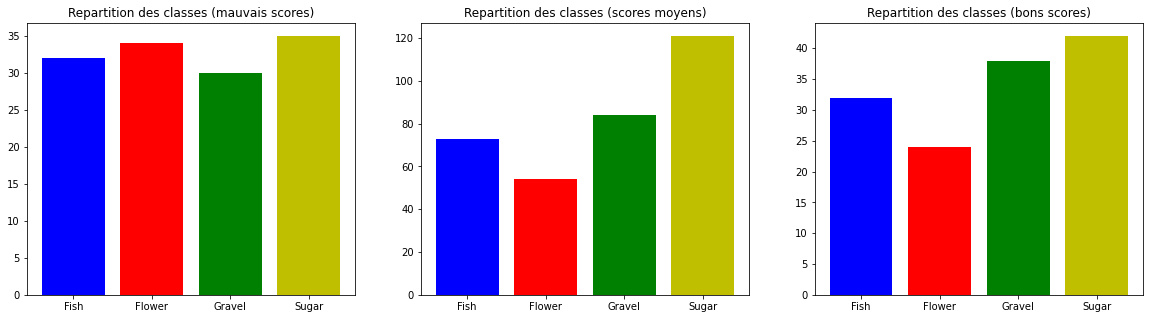

In [47]:
mauvaisScores =  y_score[y_score.cat_score == 'mauvais']
moyenScores =  y_score[y_score.cat_score == 'moyen']
bonScores =  y_score[y_score.cat_score == 'bon']

colors = ['b','r','g', 'y']

fig, ax = plt.subplots(figsize=(20, 5))

plt.subplot(1,3,1)
plt.bar(labels.values, mauvaisScores[labels.values].sum(), color=colors)
plt.title("Repartition des classes (mauvais scores)")

plt.subplot(1,3,2)
plt.bar(labels.values, moyenScores[labels.values].sum(), color=colors)
plt.title("Repartition des classes (scores moyens)")

plt.subplot(1,3,3)
plt.bar(labels.values, bonScores[labels.values].sum(), color=colors)
plt.title("Repartition des classes (bons scores)")

plt.show()